In [ ]:
#!/usr/bin/python3
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import numpy as np
import random

In [ ]:
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [ ]:
#! rm -rf dl-sport-detection
! git clone https://github.com/bobarna/dl-sport-detection.git

fatal: destination path 'dl-sport-detection' already exists and is not an empty directory.


# Data loading

## Generating Label list from first-level subfolders of the data folder


In [ ]:
# data directory path
data_dir = './dl-sport-detection/data'

In [ ]:
includedLabels = [
    #"badminton",
    #"baseball",
    #"basketball",
    "boxing",
    #"chess",
    #"cricket",
    #"fencing",
    "football",
    #"formula1",
    #"gymnastics",
    #"hockey",
    "ice_hockey",
    "kabaddi",
    #"motogp",
    "shooting",
    "swimming",
    #"table_tennis",
    #"tennis",
    #"volleyball",
    #"weight_lifting",
    #"wrestling",
    #"wwe"
]

# first-level subfolders in the data directory
labels = [ item for item in sorted(os.listdir(data_dir)) if
           os.path.isdir(os.path.join(data_dir, item)) ]
            #and item in includedLabels] # comment out if you want to include all labels


# for label in labels:
#     print(label)
print("Number of different sports labels: ", len(labels))


label_dir_paths = []
for l in labels:
    label_dir_paths.append(os.path.join(data_dir, l))

label_list = []
for i, l in enumerate(labels):
    print(i, "->",l.split("/")[-1])
    label_list.append(l.split("/")[-1])

def number_to_category(number):
    return label_list[number]

Number of different sports labels:  22
0 -> badminton
1 -> baseball
2 -> basketball
3 -> boxing
4 -> chess
5 -> cricket
6 -> fencing
7 -> football
8 -> formula1
9 -> gymnastics
10 -> hockey
11 -> ice_hockey
12 -> kabaddi
13 -> motogp
14 -> shooting
15 -> swimming
16 -> table_tennis
17 -> tennis
18 -> volleyball
19 -> weight_lifting
20 -> wrestling
21 -> wwe


In [ ]:
# Generating list of image paths
# path of images
X_paths = []
# label of the image
Y = []

# Filling up the path for X values
# Filling up the Y values
for label_dir in label_dir_paths:
    # strips everything before the last part of the path
    curr_label = os.path.basename(os.path.normpath(label_dir))
    # scandir returns the files in arbitrary order
    for img in os.scandir(label_dir):
        X_paths.append(img.path)
        # array of: 1 for its label, 0 for other labels
        Y.append([1 if curr_label==l else 0 for l in labels])

In [ ]:
#print path of image -> [0... 1 ...0]
#for i in range(len(X_paths)):
#    print(X_paths[i] + " -> " + str(Y[i]))
print(len(X_paths))

14568


In [ ]:
X = []
Y_filtered = []
X_file_names = []

IMG_SIZE = 64

# Fill X values
for i in range(len(X_paths)):
    curr_image = X_paths[i]
    if (
        curr_image.split(".")[-1] != "jpg" and
        curr_image.split(".")[-1] != "jpeg" and
        curr_image.split(".")[-1] != "png" and
        curr_image.split(".")[-1] != "JPG" and
        curr_image.split(".")[-1] != "PNG"
            ):
            # label should be erased
            continue
    X_file_names.append(curr_image)
    X.append(
        cv2.resize( 
            cv2.imread(curr_image, cv2.IMREAD_COLOR), 
            (IMG_SIZE, IMG_SIZE),
            interpolation=cv2.INTER_CUBIC 
        )
    )
    Y_filtered.append(Y[i])

In [ ]:
# Convert to numpy array
X = np.array(X)
Y = np.array(Y_filtered)
print('Shape of image is: {}'.format(X.shape))
print('Shape of labels is: {}'.format(Y.shape))

Shape of image is: (14356, 64, 64, 3)
Shape of labels is: (14356, 22)


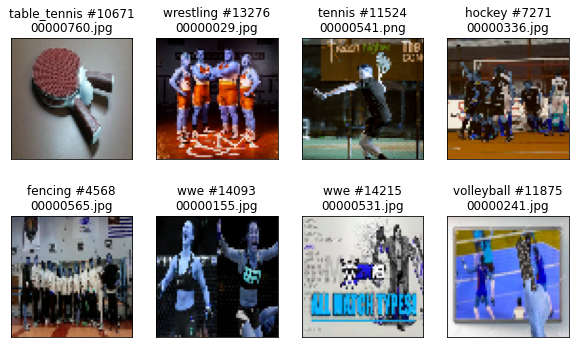

In [ ]:
f, axarr = plt.subplots(2, 4,figsize=(10, 6))

Y_number = np.argmax(Y,1)

# Display random images from the resized dataset
# Note: For some images, the colors are strange, although it doesn't really matter
# as this is only FYI visualization

for i in range(8):
    curr = random.randrange(len(X))
    img = X[curr]
    axarr[i//4, i%4].imshow(img)
    title = "{} #{}\n{}".format(number_to_category(Y_number[curr]), curr, (X_file_names[curr].split("/")[-1]))
    axarr[i//4, i%4].set_title(title)
    # Hide grid lines
    axarr[i//4,i%4].grid(False)
    # Hide axes ticks
    axarr[i//4,i%4].set_xticks([])
    axarr[i//4,i%4].set_yticks([])



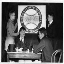

(64, 64, 3)
<class 'numpy.ndarray'>


In [ ]:
# inspecet one image

from google.colab.patches import cv2_imshow
cv2_imshow(X[3230])

#print(X[3230]/255)
print(X[3230].shape)
print(type(X[3230]))

## Generating train, test and valid data

In [ ]:
# we need a seperation that contains the same amount of pics from all categories
# train_split = 0.7
# valid_split = 0.2
# test_split = 0.1

train_indices = []
valid_indices = []
test_indices = []

for i in range (X.shape[0]):
    if i%10 == 0:
        test_indices.append(i)
    elif i%10 < 3:
        valid_indices.append(i)
    else:
        train_indices.append(i)

In [ ]:
X_train = X[train_indices]
Y_train = Y[train_indices]
X_valid = X[valid_indices]
Y_valid = Y[valid_indices]
X_test = X[test_indices]
Y_test = Y[test_indices]

In [ ]:
print('Shape of X_train is: {}'.format(X_train.shape))
print('Shape of Y_train is: {}'.format(Y_train.shape))

Shape of X_train is: (10048, 64, 64, 3)
Shape of Y_train is: (10048, 22)


## Reshape data

In [ ]:
# reshape 3D tensors to 2D tensors
# flat_size = 64*64*3 # size after flattening
#X_train = X_train.reshape(-1, flat_size)Epoch 1/100 
#X_valid = X_valid.reshape(-1, flat_size)
#X_test = X_test.reshape(-1, flat_size)

# it is in int8 format, the neural network requires float32
X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
X_test = X_test.astype("float32")

# scale the values to 0...1
X_train /= 255
X_valid /= 255
X_test /= 255

# output is already one-hot-encoded

In [ ]:
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test: ", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_valid:", Y_valid.shape)
print("Y_test: ", Y_test.shape)

nb_classes = Y_train.shape[1]
print(np.asarray(range(nb_classes)))
print(Y_test[0].astype(np.int))

X_train: (10048, 64, 64, 3)
X_valid: (2872, 64, 64, 3)
X_test:  (1436, 64, 64, 3)
Y_train: (10048, 22)
Y_valid: (2872, 22)
Y_test:  (1436, 22)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#Training

## Create and train model

In [ ]:
# based on our MNIST practice
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3,))) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.75))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.75))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [ ]:
patience=10
es = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1)

network_history = model.fit(X_train, Y_train, batch_size=64, 
                            validation_data = (X_valid, Y_valid),
                            epochs=10000, verbose=1, callbacks=[es, checkpointer],
                            shuffle=True)

Epoch 1/10000
157/157 [==============================] - 1s 8ms/step - loss: 1.6910 - accuracy: 0.4894 - val_loss: 1.3707 - val_accuracy: 0.6724

Epoch 00001: val_loss improved from inf to 1.37074, saving model to model.hdf5
Epoch 2/10000
157/157 [==============================] - 1s 8ms/step - loss: 1.6438 - accuracy: 0.4989 - val_loss: 1.3930 - val_accuracy: 0.6546

Epoch 00002: val_loss did not improve from 1.37074
Epoch 3/10000
157/157 [==============================] - 1s 8ms/step - loss: 1.6372 - accuracy: 0.5013 - val_loss: 1.4490 - val_accuracy: 0.6549

Epoch 00003: val_loss did not improve from 1.37074
Epoch 4/10000
157/157 [==============================] - 1s 8ms/step - loss: 1.6439 - accuracy: 0.5024 - val_loss: 1.4154 - val_accuracy: 0.6508

Epoch 00004: val_loss did not improve from 1.37074
Epoch 5/10000
157/157 [==============================] - 1s 8ms/step - loss: 1.6272 - accuracy: 0.5054 - val_loss: 1.4331 - val_accuracy: 0.6490

Epoch 00005: val_loss did not improve 

## Import model trained earlier

In [ ]:
# import model trained in an earlier run
model = tensorflow.keras.models.load_model("dl-sport-detection/best_model_53_75.hdf5")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

Please note:
When we loaded a model trained in an earlier session, we overwrote these graphs.


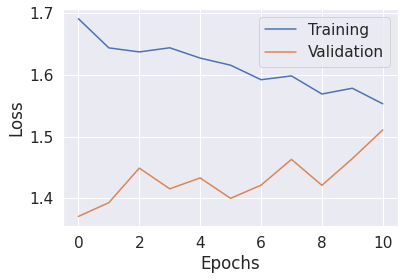

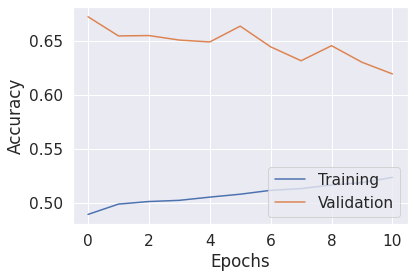

In [ ]:
# Please note: 
## When we loaded a model trained in an earlier session, we overwrote these graphs.

print("Please note:")
print("When we loaded a model trained in an earlier session, we overwrote these graphs.")
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

# Evaluation

In [ ]:
# evaluate on test data
test_loss = model.evaluate(X_test, Y_test)

45/45 [==============================] - 0s 3ms/step - loss: 1.2518 - accuracy: 0.6838


In [ ]:
# make predictions
Y_pred = model.predict(X_test)

true    = 0
false   = 0

for pred, actual in zip(np.argmax(Y_pred, 1), np.argmax(Y_test, 1)):
    if pred == actual:
        true = true + 1
    else:
        false = false + 1

print("True: {} ({}%)\nFalse: {}".format(true, true/(true+false), false))




True: 982 (0.6838440111420613%)
False: 454


10 randomly selected predictions
-------------------------------------------------------


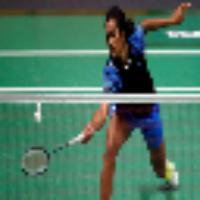

Top three predictions: badminton (84.62%), swimming (6.85%), table_tennis (2.95%)
Labeled as badminton



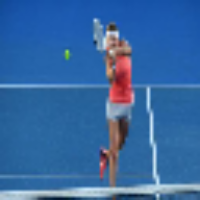

Top three predictions: tennis (87.93%), weight_lifting (3.02%), table_tennis (2.78%)
Labeled as tennis



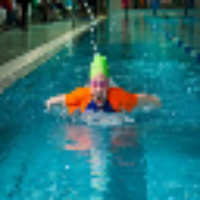

Top three predictions: swimming (83.15%), tennis (9.28%), badminton (3.69%)
Labeled as swimming



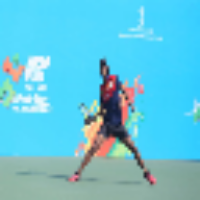

Top three predictions: swimming (50.60%), tennis (18.59%), weight_lifting (8.46%)
Labeled as tennis



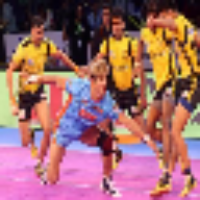

Top three predictions: kabaddi (99.74%), wrestling (0.13%), gymnastics (0.06%)
Labeled as kabaddi



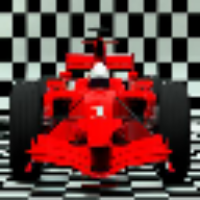

Top three predictions: formula1 (98.98%), table_tennis (0.70%), motogp (0.14%)
Labeled as formula1



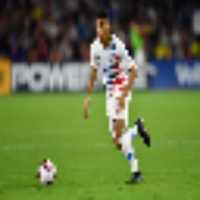

Top three predictions: football (89.96%), baseball (4.10%), hockey (3.39%)
Labeled as football



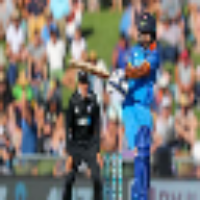

Top three predictions: cricket (36.23%), wrestling (12.34%), shooting (6.53%)
Labeled as cricket



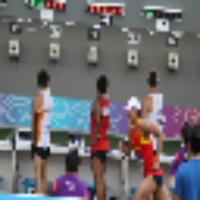

Top three predictions: formula1 (14.88%), shooting (9.89%), table_tennis (9.72%)
Labeled as shooting



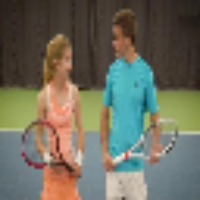

Top three predictions: shooting (19.96%), wrestling (10.29%), chess (6.80%)
Labeled as tennis



In [ ]:
np.set_printoptions(precision=2, suppress=True)

print("10 randomly selected predictions")
print("-"*len("10 randomly selected predictions with the ground truth:"))

for i in (np.random.rand(10) * len(Y_test)).astype(int):
    cv2_imshow(cv2.resize(X_test[i]*255, (200, 200)))
    top_preds = Y_pred[i].argsort()[-3:][::-1]
    print("Top three predictions: {} ({:.2f}%), {} ({:.2f}%), {} ({:.2f}%)".format(
        number_to_category(top_preds[0]), Y_pred[i][top_preds[0]]*100,
        number_to_category(top_preds[1]), Y_pred[i][top_preds[1]]*100,
        number_to_category(top_preds[2]), Y_pred[i][top_preds[2]]*100,
        ))
    print("Labeled as", number_to_category(np.argmax(Y_test, 1)[i]))
    #print("Prediction:   ",*np.round(Y_pred[i],2), sep="\t")
    #print("Ground truth: ",*Y_test[i], sep="\t")
    print()

Test accuracy: 0.683844
Precision 0.7042441622694445
Recall 0.6729324065854599
F1 score 0.6743462798335959
Confusion matrix: 


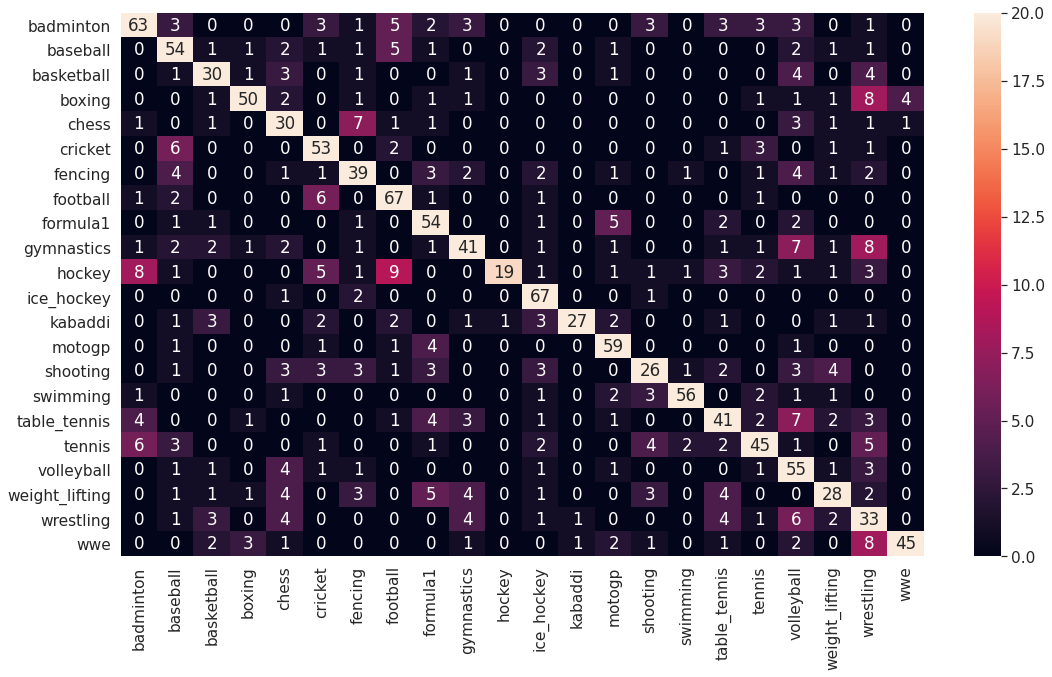

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import seaborn as sns

Y_true_nr = np.argmax(Y_test, 1)
Y_pred_nr = np.argmax(Y_pred, 1)

axis_labels = [number_to_category(x) for x in range(nb_classes)]


print("Test accuracy: %g" %(accuracy_score(Y_true_nr, Y_pred_nr)))
print("Precision", precision_score(Y_true_nr, Y_pred_nr, average="macro"))
print("Recall", recall_score(Y_true_nr, Y_pred_nr, average="macro"))
print("F1 score", f1_score(Y_true_nr, Y_pred_nr, average="macro"))
print("Confusion matrix: ")
conf=confusion_matrix(Y_true_nr, Y_pred_nr)
plt.figure(figsize=(18,10))
sns.set(font_scale=1.4)
sns.heatmap(conf, 
            annot=True, 
            xticklabels=axis_labels, 
            yticklabels=axis_labels,
            fmt='d', 
            vmax=20)


# list all the available classes
#for i, l in enumerate(labels):
#    print(i, "->",l.split("/")[-1])


# Our photos

In [ ]:
! rm -r our_photos our_photos.zip
! wget http://home.sch.bme.hu/~bobarna/upload/our_photos.zip
! unzip our_photos.zip -d our_photos > /dev/null

--2021-05-11 11:40:24--  http://home.sch.bme.hu/~bobarna/upload/our_photos.zip
Resolving home.sch.bme.hu (home.sch.bme.hu)... 152.66.208.100, 2001:738:2001:207b:0:208:100:0
Connecting to home.sch.bme.hu (home.sch.bme.hu)|152.66.208.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4727537 (4.5M) [application/zip]
Saving to: ‘our_photos.zip’

our_photos.zip      100%[===================>]   4.51M  3.54MB/s    in 1.3s    

2021-05-11 11:40:26 (3.54 MB/s) - ‘our_photos.zip’ saved [4727537/4727537]



In [ ]:
X_our_photos_original = []
X_our_photos = []
X_our_photos_paths = []


for img in os.scandir("our_photos"):
    X_our_photos_paths.append(img.path)

IMG_SIZE = 64

# Fill X values
for i in range(len(X_our_photos_paths)):
    curr_image = X_our_photos_paths[i]
    X_our_photos_original.append(cv2.imread(curr_image, cv2.IMREAD_COLOR))
    X_our_photos.append(
        cv2.resize( 
            cv2.imread(curr_image, cv2.IMREAD_COLOR), 
            (IMG_SIZE, IMG_SIZE),
            interpolation=cv2.INTER_CUBIC 
        )
    )

# Convert to numpy array
X_our_photos = np.array(X_our_photos)/255
print('Shape of our photos is: {}'.format(X_our_photos.shape))

Shape of our photos is: (7, 64, 64, 3)


In [ ]:
# make predictions
Y_pred_our_photos = model.predict(X_our_photos)


In [ ]:
print(Y_pred_our_photos[1])
print("---")
print(Y_pred_our_photos[1].argsort()[-3:][::-1])
print("---")
Y_pred_our_photos[1].argsort()[-3:][::-1]


[0.   0.   0.02 0.   0.21 0.01 0.04 0.   0.   0.02 0.   0.   0.   0.
 0.02 0.   0.01 0.   0.63 0.01 0.01 0.  ]
---
[18  4  6]
---


array([18,  4,  6])

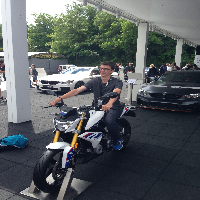

Top three predictions: formula1 (29.36%), weight_lifting (18.38%), table_tennis (8.90%)


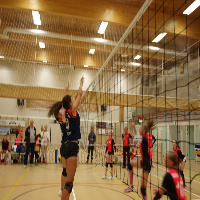

Top three predictions: volleyball (62.56%), chess (21.05%), fencing (4.32%)


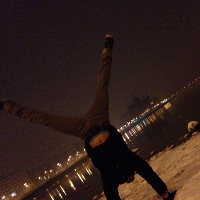

Top three predictions: gymnastics (20.09%), chess (12.48%), basketball (12.43%)


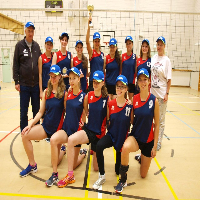

Top three predictions: volleyball (39.18%), gymnastics (16.66%), shooting (9.16%)


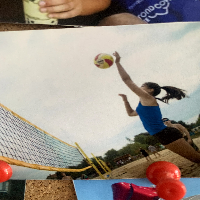

Top three predictions: volleyball (24.99%), fencing (17.54%), gymnastics (11.21%)


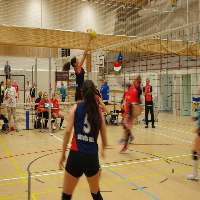

Top three predictions: volleyball (65.03%), shooting (8.56%), gymnastics (7.63%)


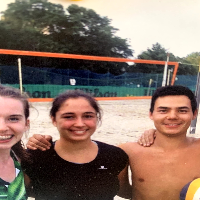

Top three predictions: volleyball (46.90%), shooting (16.40%), gymnastics (4.90%)


In [ ]:
# inspect the predictions

from google.colab.patches import cv2_imshow

for i in range(len(X_our_photos)):
    cv2_imshow(cv2.resize(X_our_photos_original[i], (200, 200)))
    #cv2_imshow(X_our_photos[i])
    # calculate top 3 predictions
    top_preds = Y_pred_our_photos[i].argsort()[-3:][::-1]
    print("Top three predictions: {} ({:.2f}%), {} ({:.2f}%), {} ({:.2f}%)".format(
        number_to_category(top_preds[0]), Y_pred_our_photos[i][top_preds[0]]*100,
        number_to_category(top_preds[1]), Y_pred_our_photos[i][top_preds[1]]*100,
        number_to_category(top_preds[2]), Y_pred_our_photos[i][top_preds[2]]*100,
        ))
    #print(number_to_category(np.argmax(Y_pred_our_photos, 1)[i]))
    #print("Predictions:  ",*Y_pred_our_photos[i], sep="\t")